<a href="https://colab.research.google.com/github/pratiksha2409/PneumoniaDetection/blob/main/PneumoniaDetectionProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:33<00:00, 26.9MB/s]
100% 2.29G/2.29G [01:33<00:00, 26.2MB/s]


In [ ]:
import zipfile
zip_ext = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ext.extractall('/content')
zip_ext.close()

In [ ]:

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D,Dense,Flatten,Dropout


In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    '/content/chest_xray/train',
    image_size = (256,256),
    batch_size = 32,
    labels = 'inferred',
    label_mode = 'int'

)

test_ds = keras.utils.image_dataset_from_directory(
    '/content/chest_xray/test',
    image_size = (256,256),
    batch_size = 32,
    labels = 'inferred',
    label_mode = 'binary'

)

val_ds = keras.utils.image_dataset_from_directory(
    '/content/chest_xray/val',
    image_size = (256,256),
    batch_size = 32,
    labels = 'inferred',
    label_mode = 'binary'

)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt

([<matplotlib.patches.Wedge at 0x78d6ec0ead70>,
 [Text(-1.0768670906484026, 0.40355578186719787, 'train'),
  Text(1.023306276583389, -0.4035396688121763, 'test'),
  Text(1.0998396687459067, -0.01878039011560862, 'val')],
 [Text(-0.6086640077577927, 0.22809674627276397, '88.6%'),
  Text(0.5581670599545757, -0.2201125466248234, '10.9%'),
  Text(0.5999125465886763, -0.010243849153968337, '0.5%')])

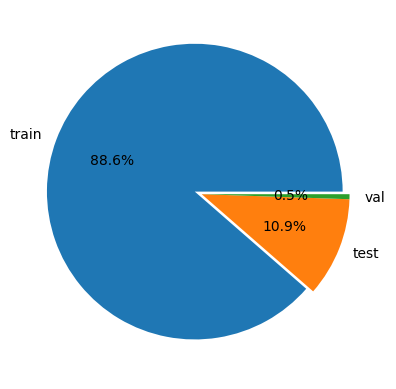

In [ ]:
plt.pie([len(train_ds),len(test_ds),len(val_ds)],labels = ['train','test','val'],autopct= '%.1f%%',explode = (0.05, 0, 0))


In [ ]:
print(train_ds.class_names)
print(val_ds.class_names)
print(test_ds.class_names)


['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


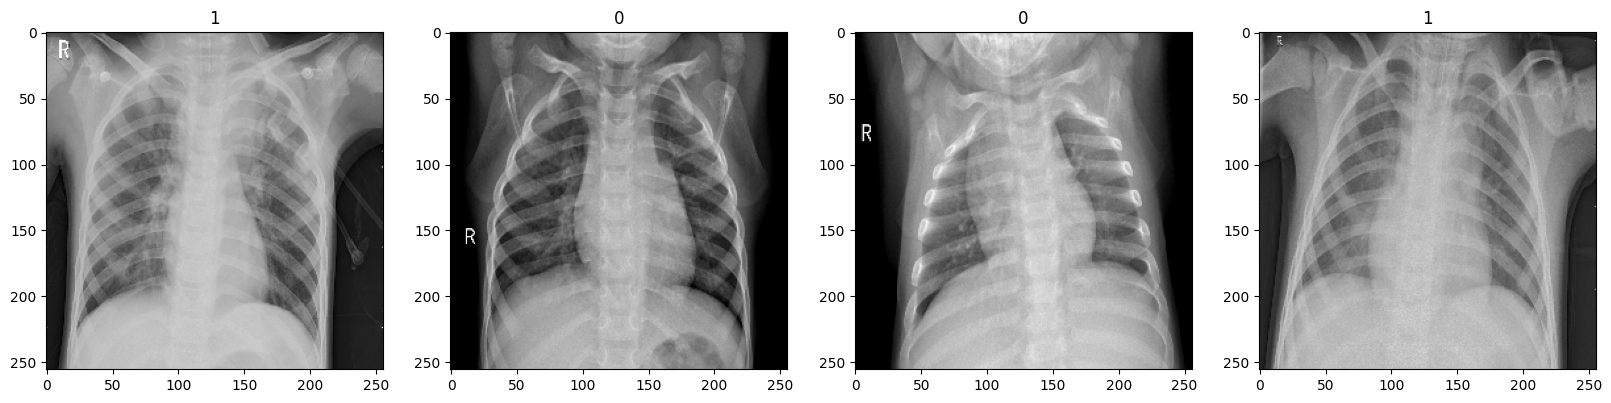

In [ ]:
data_iterator = train_ds.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label
train_ds = train_ds.map(process)
test_ds = test_ds.map(process)
val_ds = val_ds.map(process)

In [ ]:
from keras.applications.vgg16 import VGG16


In [ ]:
conv_base = VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape=(256,256,3)
)


58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [ ]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())



model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(Dropout(0.3))



model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 18909249 (72.13 MB)
Trainable params: 11273985 (43.01 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


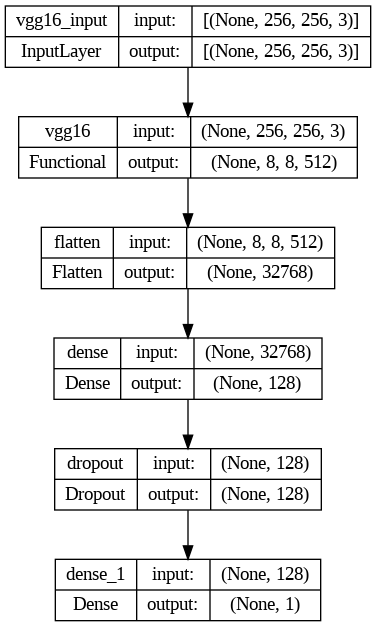

In [ ]:
keras.utils.plot_model(model, show_shapes=True)


In [ ]:
history = model.fit(train_ds,epochs=10,validation_data =val_ds)


Epoch 1/10
163/163 [==============================] - 55s 248ms/step - loss: 1.2299 - accuracy: 0.7542 - val_loss: 0.4331 - val_accuracy: 0.8750
Epoch 2/10
163/163 [==============================] - 38s 220ms/step - loss: 0.2348 - accuracy: 0.9387 - val_loss: 0.2139 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 39s 229ms/step - loss: 0.1158 - accuracy: 0.9705 - val_loss: 0.3537 - val_accuracy: 0.7500
Epoch 4/10
163/163 [==============================] - 38s 226ms/step - loss: 0.0688 - accuracy: 0.9833 - val_loss: 0.0589 - val_accuracy: 1.0000
Epoch 5/10
163/163 [==============================] - 38s 216ms/step - loss: 0.0595 - accuracy: 0.9862 - val_loss: 0.0349 - val_accuracy: 1.0000
Epoch 6/10
163/163 [==============================] - 38s 222ms/step - loss: 0.0646 - accuracy: 0.9856 - val_loss: 0.0219 - val_accuracy: 1.0000
Epoch 7/10
163/163 [==============================] - 38s 221ms/step - loss: 0.0312 - accuracy: 0.9950 - val_loss: 0.0260 - val_ac

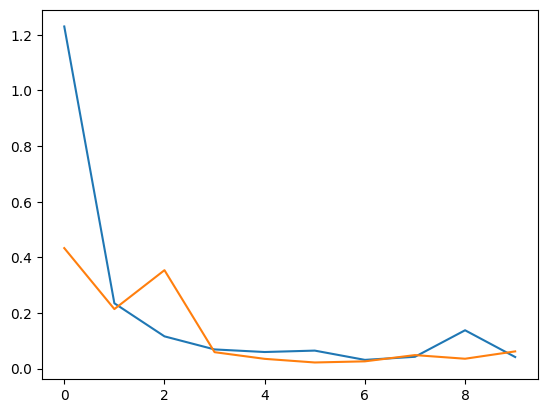

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
model.save('/content/prat_trained_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.7 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
!pip install googletrans

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 11.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15718 sha256=e83294e048bb62db34c56fb8f1fb9a44811d7ae66eea1c19ec4af073147cc030
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling ch

In [ ]:
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np
from googletrans import Translator

# Load your custom-trained VGG16 model
model_path = '/content/prat_trained_model.h5'  # Replace with the actual path
loaded_model = load_model(model_path)

# Image preprocessing pipeline
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image
    return img_array

# Translate text to Indian languages
def translate_to_indian(text, language):
    translator = Translator()
    translation = translator.translate(text, src='en', dest=language)
    return translation.text

# Define translation dictionaries
translation_dict = {
    "English": {
        "title": "Pneumonia Detection App",
        "button_predict": "Predict",
        "button_upload": "Choose an image...",
        "prediction_detected": "The model predicts: Pneumonia Detected",
        "prediction_not_detected": "The model predicts: No Pneumonia Detected"
    },
    "Hindi": {
        "title": "न्यूमोनिया पहचान ऐप",
        "button_predict": "भविष्यवाणी करें",
        "button_upload": "एक छवि चुनें...",
        "prediction_detected": "यह मॉडल अनुमान लगाता है: प्नेमोनिया खोजा गया",
        "prediction_not_detected": "यह मॉडल अनुमान लगाता है: कोई प्नेमोनिया नहीं खोजा गया"
    },
    "Bengali": {
        "title": "নিউমোনিয়া শনাক্ত অ্যাপ",
        "button_predict": "অনুমান করুন",
        "button_upload": "একটি ছবি নির্বাচন করুন...",
        "prediction_detected": "মডেলটি অনুমান করে: নিউমোনিয়া শনাক্ত করা হয়েছে",
        "prediction_not_detected": "মডেলটি অনুমান করে: কোন নিউমোনিয়া শনাক্ত করা হয়নি"
    },
    "Tamil": {
        "title": "நோய் உடற்பயிற்சி பயன்பாடு",
        "button_predict": "கணிப்பொறியுங்கள்",
        "button_upload": "ஒரு படத்தைத் தேர்வு செய்க...",
        "prediction_detected": "மாதிரியான போல் நோய் கண்டறியப்படுகிறது: நோய் கண்டறியப்படுகிறது",
        "prediction_not_detected": "மாதிரியான போல் நோய் கண்டறியப்படவில்லை: நோய் கண்டறியப்படவில்லை"
    },
    "Marathi": {
        "title": "न्यूमोनिया शोध अ‍ॅप",
        "button_predict": "अंदाज लावा",
        "button_upload": "एक चित्र निवडा...",
        "prediction_detected": "मॉडेलने अंदाज लावला आहे: न्यूमोनिया ओळखली",
        "prediction_not_detected": "मॉडेलने अंदाज लावला नाही: कोणतेही न्यूमोनिया ओळखले नाही"
    },
    # Add translations for other Indian languages
    # "Language": {
    #     "title": "",
    #     "button_predict": "",
    #     "button_upload": "",
    #     "prediction_detected": "",
    #     "prediction_not_detected": ""
    # }
}

# Streamlit app
def main():
    st.title(translation_dict["English"]["title"])

    # Language selection
    selected_language = st.sidebar.multiselect("Select Language", ["English", "Hindi", "Bengali", "Tamil","Marathi"])

    # Set language-specific translations
    if selected_language:
        language = selected_language[0]
    else:
        language = "English"

    # Upload image through Streamlit
    uploaded_file = st.file_uploader(translation_dict[language]["button_upload"], type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        # Display the uploaded image
        st.image(uploaded_file, caption=translation_dict[language]["button_upload"], use_column_width=True)

        # Allow the user to make predictions
        if st.button(translation_dict[language]["button_predict"]):
            # Preprocess the image and make predictions
            img_array = preprocess_image(uploaded_file)
            prediction = loaded_model.predict(img_array)

            # Display the prediction result
            st.subheader("Prediction:")
            if prediction > 0.5:
                st.write(translation_dict[language]["prediction_detected"])
            else:
                st.write(translation_dict[language]["prediction_not_detected"])

# Run the Streamlit app
if __name__ == '__main__':
    main()

Overwriting app.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.87.153.36


In [ ]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 1s (128 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.3_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.3) ...
Setting up poppler-utils (22.02.0-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.87.153.36:8501

npx: installed 22 in 1.596s
your url is: https://itchy-books-divide.loca.lt
2024-04-27 17:16:30.403061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-27 17:16:33.104828: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1714238274.337127    5503 service.cc:145] XLA service 0x7f7c24002d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714238274.337171    5503 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-27 17:17:55.690918: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.14GiB with fr